
Q-Learning Final Policies (10 runs):
Run 1: ['a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a3', 'a3', 'a3', 'a2', 'a4', 'a2', 'a2', 'a2']
Run 2: ['a2', 'a3', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a3', 'a4', 'a2', 'a2', 'a1', 'a2', 'a2', 'a2']
Run 3: ['a2', 'a3', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a3', 'a2', 'a4', 'a2', 'a4', 'a1', 'a2', 'a2']
Run 4: ['a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a4', 'a2', 'a2', 'a2', 'a4', 'a2', 'a2', 'a2']
Run 5: ['a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a3', 'a2', 'a2', 'a2', 'a1', 'a2', 'a2', 'a2']
Run 6: ['a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a3', 'a2', 'a2', 'a2', 'a4', 'a4', 'a2', 'a2']
Run 7: ['a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a3', 'a2', 'a3', 'a2', 'a4', 'a4', 'a2', 'a2']
Run 8: ['a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a3', 'a2', 'a2', 'a2', 'a4', 'a2', 'a2', 'a2']
Run 9: ['a3', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2', 'a3', 'a2', 'a3', 'a2', 'a4', 'a4', 'a2', 'a2']
Run 10: ['a2', 'a2', 'a2',

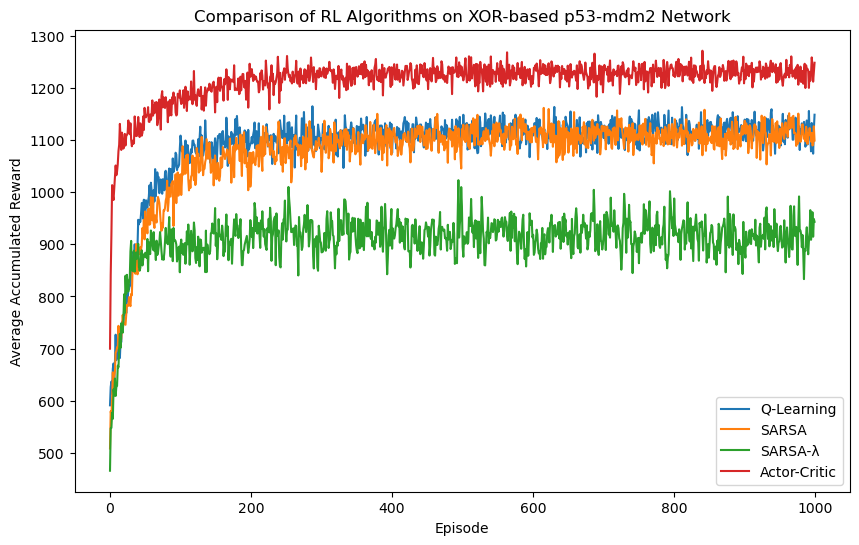

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

#########################################
# 1. Build the State Space
#########################################
def build_states():
    """
    Build all 16 states as 4-bit vectors.
    Returns:
      - states: list of 16 vectors (each a list of 4 bits)
      - state_to_index: dict mapping tuple(state) -> index
      - index_to_state: dict mapping index -> tuple(state)
    """
    states = []
    for i in range(16):
        bits = [(i >> b) & 1 for b in reversed(range(4))]
        states.append(bits)
    state_to_index = {}
    index_to_state = {}
    for idx, s_bits in enumerate(states):
        t = tuple(s_bits)
        state_to_index[t] = idx
        index_to_state[idx] = t
    return states, state_to_index, index_to_state

#########################################
# 2. Build the Action Space
#########################################
def build_actions():
    """
    Build the action space with 4 actions:
      a1 = [0, 0, 0, 0]
      a2 = [0, 1, 0, 0]
      a3 = [0, 0, 1, 0]
      a4 = [0, 0, 0, 1]
    Also returns the mapping dictionaries and the cost for each action.
    Costs: c(a1)=0, c(a2)=1, c(a3)=1, c(a4)=0.
    """
    actions = [
        [0, 0, 0, 0],  # a1
        [0, 1, 0, 0],  # a2
        [0, 0, 1, 0],  # a3
        [0, 0, 0, 1],  # a4
    ]
    index_to_action = {0: "a1", 1: "a2", 2: "a3", 3: "a4"}
    action_to_index = {}
    for i, a_bits in enumerate(actions):
        t = tuple(a_bits)
        action_to_index[t] = i

    # Define costs for each action
    action_costs = [0, 1, 1, 0]
    return actions, action_to_index, index_to_action, action_costs

#########################################
# 3. Connectivity Matrix, Threshold & XOR
#########################################
# The connectivity matrix C as given
C = np.array([
    [ 0,  0, -1,  0],
    [ 1,  0, -1, -1],
    [ 0,  1,  0,  0],
    [-1,  1,  1,  0]
], dtype=int)

def threshold_and_convert(vec):
    """
    For a given vector, if element > 0, return 1; else return 0.
    """
    return [1 if x > 0 else 0 for x in vec]

def xor_bits(vecA, vecB):
    """
    Compute the component-wise XOR between two lists of bits.
    """
    return [a ^ b for a, b in zip(vecA, vecB)]

#########################################
# 4. Environment Step Function
#########################################
def env_step(state_idx, action_idx, states, C, actions, action_costs, p, state_to_index):
    """
    Executes one step of the environment using the equation:
       s_k = v(C * s_{k-1}) XOR a_{k-1} XOR n_k
    where:
      - s_{k-1} is the current state (as a 4-bit vector)
      - a_{k-1} is the selected action
      - n_k is a noise vector with each component sampled from Bernoulli(p)
      - v(.) thresholds the vector: >0 becomes 1, <=0 becomes 0
      - XOR is computed component-wise.
    Computes also the reward:
       R = 5 * (# of ones in s_k) - c(a)
    Returns:
       - next_state_idx: index of the next state
       - reward: immediate reward
    """
    # Get current state bits.
    o_i = states[state_idx]
    
    # 1. Compute C * s and threshold
    ci = C.dot(o_i)
    ci_thresh = threshold_and_convert(ci)
    
    # 2. XOR with the action
    a_bits = actions[action_idx]
    x = xor_bits(ci_thresh, a_bits)
    
    # 3. Sample noise from Bernoulli(p) for each of 4 components.
    noise = [1 if random.random() < p else 0 for _ in range(4)]
    
    # 4. XOR with the noise to get next state bits.
    o_next_bits = xor_bits(x, noise)
    
    # 5. Compute reward: 5 per ON bit minus action cost.
    cost_a = action_costs[action_idx]
    num_on = sum(o_next_bits)
    reward = 5 * num_on - cost_a
    
    # 6. Convert next state bits into a state index.
    next_state_idx = state_to_index[tuple(o_next_bits)]
    return next_state_idx, reward

#########################################
# 5. Helper Functions for RL
#########################################
def epsilon_greedy(Q, state, epsilon):
    """
    Select an action using epsilon-greedy policy given a Q-table.
    """
    num_actions = Q.shape[1]
    if random.random() < epsilon:
        return np.random.randint(num_actions)
    else:
        return np.argmax(Q[state, :])

def get_greedy_policy(Q):
    """
    Given a Q-table, return the greedy policy (argmax for each state).
    """
    return [np.argmax(Q[s, :]) for s in range(Q.shape[0])]

def softmax(preferences):
    """
    Compute softmax probabilities for a given vector of preferences.
    """
    exps = np.exp(preferences - np.max(preferences))
    return exps / np.sum(exps)

#########################################
# 6. Q-Learning Algorithm
#########################################
def run_q_learning(num_runs=10, num_episodes=1000, max_steps=100,
                   alpha=0.25, gamma=0.9, epsilon=0.15, p=0.1):
    """
    Runs Q-Learning on the environment.
    Returns:
      - all_policies: list of final greedy policies for each run (list of lists)
      - rewards_history: array of accumulated rewards for each episode per run.
    """
    states, state_to_index, index_to_state = build_states()
    actions, action_to_index, index_to_action, action_costs = build_actions()
    num_states = len(states)
    num_actions = len(actions)
    
    all_policies = []
    rewards_history = np.zeros((num_runs, num_episodes))
    
    for run_i in range(num_runs):
        Q = np.zeros((num_states, num_actions))
        for ep in range(num_episodes):
            s = np.random.randint(0, num_states)
            ep_reward = 0.0
            for step in range(max_steps):
                a = epsilon_greedy(Q, s, epsilon)
                s_next, r = env_step(s, a, states, C, actions, action_costs, p, state_to_index)
                best_next = np.max(Q[s_next, :])
                td_target = r + gamma * best_next
                td_error = td_target - Q[s, a]
                Q[s, a] += alpha * td_error
                ep_reward += r
                s = s_next
            rewards_history[run_i, ep] = ep_reward
        final_policy = get_greedy_policy(Q)
        all_policies.append(final_policy)
    return all_policies, rewards_history

#########################################
# 7. SARSA Algorithm
#########################################
def run_sarsa(num_runs=10, num_episodes=1000, max_steps=100,
              alpha=0.25, gamma=0.9, epsilon=0.15, p=0.1):
    """
    Runs SARSA (on-policy) on the environment.
    """
    states, state_to_index, index_to_state = build_states()
    actions, action_to_index, index_to_action, action_costs = build_actions()
    num_states = len(states)
    num_actions = len(actions)
    
    all_policies = []
    rewards_history = np.zeros((num_runs, num_episodes))
    
    for run_i in range(num_runs):
        Q = np.zeros((num_states, num_actions))
        for ep in range(num_episodes):
            s = np.random.randint(0, num_states)
            a = epsilon_greedy(Q, s, epsilon)
            ep_reward = 0.0
            for step in range(max_steps):
                s_next, r = env_step(s, a, states, C, actions, action_costs, p, state_to_index)
                a_next = epsilon_greedy(Q, s_next, epsilon)
                td_target = r + gamma * Q[s_next, a_next]
                td_error = td_target - Q[s, a]
                Q[s, a] += alpha * td_error
                ep_reward += r
                s, a = s_next, a_next
            rewards_history[run_i, ep] = ep_reward
        final_policy = get_greedy_policy(Q)
        all_policies.append(final_policy)
    return all_policies, rewards_history

#########################################
# 8. SARSA-λ Algorithm (with Eligibility Traces)
#########################################
def run_sarsa_lambda(num_runs=10, num_episodes=1000, max_steps=100,
                     alpha=0.25, gamma=0.9, epsilon=0.15, lam=0.95, p=0.1):
    """
    Runs SARSA-λ on the environment using eligibility traces.
    """
    states, state_to_index, index_to_state = build_states()
    actions, action_to_index, index_to_action, action_costs = build_actions()
    num_states = len(states)
    num_actions = len(actions)
    
    all_policies = []
    rewards_history = np.zeros((num_runs, num_episodes))
    
    for run_i in range(num_runs):
        Q = np.zeros((num_states, num_actions))
        for ep in range(num_episodes):
            # Initialize eligibility traces for each episode.
            E = np.zeros((num_states, num_actions))
            s = np.random.randint(0, num_states)
            a = epsilon_greedy(Q, s, epsilon)
            ep_reward = 0.0
            for step in range(max_steps):
                s_next, r = env_step(s, a, states, C, actions, action_costs, p, state_to_index)
                a_next = epsilon_greedy(Q, s_next, epsilon)
                # Increment eligibility trace for current state-action pair.
                E[s, a] += 1.0
                td_target = r + gamma * Q[s_next, a_next]
                delta = td_target - Q[s, a]
                # Update Q for all state-action pairs.
                Q += alpha * delta * E
                # Decay the eligibility traces.
                E *= gamma * lam
                ep_reward += r
                s, a = s_next, a_next
            rewards_history[run_i, ep] = ep_reward
        final_policy = get_greedy_policy(Q)
        all_policies.append(final_policy)
    return all_policies, rewards_history

#########################################
# 9. Tabular Actor-Critic Algorithm
#########################################
def run_actor_critic(num_runs=10, num_episodes=1000, max_steps=100,
                     alpha_v=0.25, beta=0.05, gamma=0.9, p=0.1):
    """
    Runs a tabular Actor-Critic algorithm on the environment.
    Uses a softmax policy based on action preferences.
    """
    states, state_to_index, index_to_state = build_states()
    actions, action_to_index, index_to_action, action_costs = build_actions()
    num_states = len(states)
    num_actions = len(actions)
    
    all_policies = []
    rewards_history = np.zeros((num_runs, num_episodes))
    
    for run_i in range(num_runs):
        # Initialize state-value function V(s) and action preferences h(s,a).
        V = np.zeros(num_states)
        preferences = np.zeros((num_states, num_actions))
        for ep in range(num_episodes):
            s = np.random.randint(0, num_states)
            ep_reward = 0.0
            for step in range(max_steps):
                # Compute softmax policy from preferences.
                pi_s = softmax(preferences[s])
                a = np.random.choice(num_actions, p=pi_s)
                s_next, r = env_step(s, a, states, C, actions, action_costs, p, state_to_index)
                # TD error.
                delta = r + gamma * V[s_next] - V[s]
                # Update value function.
                V[s] += alpha_v * delta
                # Update policy preferences.
                for a2 in range(num_actions):
                    if a2 == a:
                        preferences[s, a2] += beta * delta * (1 - pi_s[a2])
                    else:
                        preferences[s, a2] -= beta * delta * pi_s[a2]
                ep_reward += r
                s = s_next
            rewards_history[run_i, ep] = ep_reward
        # Derive final policy from the preferences using softmax.
        final_policy = []
        for s_idx in range(num_states):
            pi_s = softmax(preferences[s_idx])
            best_a = np.argmax(pi_s)
            final_policy.append(best_a)
        all_policies.append(final_policy)
    return all_policies, rewards_history

#########################################
# 10. Main Function to Run Experiments
#########################################
def main():
    # Hyperparameters (feel free to adjust these)
    p = 0.1         # Bernoulli noise parameter
    gamma = 0.9     # Discount factor
    alpha = 0.25    # Learning rate for Q-learning/SARSA/SARSA-λ
    epsilon = 0.15  # Epsilon for epsilon-greedy
    lam = 0.95      # Lambda for SARSA-λ
    beta = 0.05     # Learning rate for Actor-Critic policy update
    num_runs = 10
    num_episodes = 1000
    max_steps = 100

    # Run Q-Learning
    ql_policies, ql_rewards = run_q_learning(num_runs, num_episodes, max_steps,
                                             alpha, gamma, epsilon, p)
    # Run SARSA
    sarsa_policies, sarsa_rewards = run_sarsa(num_runs, num_episodes, max_steps,
                                              alpha, gamma, epsilon, p)
    # Run SARSA-λ
    sarsal_policies, sarsal_rewards = run_sarsa_lambda(num_runs, num_episodes, max_steps,
                                                       alpha, gamma, epsilon, lam, p)
    # Run Actor-Critic
    ac_policies, ac_rewards = run_actor_critic(num_runs, num_episodes, max_steps,
                                               alpha_v=alpha, beta=beta, gamma=gamma, p=p)

    # Retrieve action label mapping.
    _, _, index_to_action, _ = build_actions()

    # Print final policies for each algorithm using action labels.
    print("\nQ-Learning Final Policies (10 runs):")
    for i, pol in enumerate(ql_policies):
        pol_labels = [index_to_action[a] for a in pol]
        print(f"Run {i+1}: {pol_labels}")

    print("\nSARSA Final Policies (10 runs):")
    for i, pol in enumerate(sarsa_policies):
        pol_labels = [index_to_action[a] for a in pol]
        print(f"Run {i+1}: {pol_labels}")

    print("\nSARSA-λ Final Policies (10 runs):")
    for i, pol in enumerate(sarsal_policies):
        pol_labels = [index_to_action[a] for a in pol]
        print(f"Run {i+1}: {pol_labels}")

    print("\nActor-Critic Final Policies (10 runs):")
    for i, pol in enumerate(ac_policies):
        pol_labels = [index_to_action[a] for a in pol]
        print(f"Run {i+1}: {pol_labels}")

    # Compute mean accumulated reward per episode for each algorithm over the 10 runs.
    mean_ql = np.mean(ql_rewards, axis=0)
    mean_sarsa = np.mean(sarsa_rewards, axis=0)
    mean_sarsal = np.mean(sarsal_rewards, axis=0)
    mean_ac = np.mean(ac_rewards, axis=0)

    # Plot the learning curves.
    plt.figure(figsize=(10, 6))
    plt.plot(mean_ql, label='Q-Learning')
    plt.plot(mean_sarsa, label='SARSA')
    plt.plot(mean_sarsal, label='SARSA-λ')
    plt.plot(mean_ac, label='Actor-Critic')
    plt.xlabel("Episode")
    plt.ylabel("Average Accumulated Reward")
    plt.title("Comparison of RL Algorithms on XOR-based p53-mdm2 Network")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()